# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [1]:
#| default_exp pbh

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#| export
class Pbh:
    """A class to represent a PBH population"""

    def __init__(self,
                m_pbh: float, # PBH mass in solar masses
                f_dm: float # PBH fraction of the DM density
                ):
        """
        Initialize the PBH population
        """
        self.m_pbh = m_pbh
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
    
    def __str__(self) -> str:
        return f"PBH population with m_pbh={self.m_pbh} and f_dm={self.f_dm}"
    __repr__ = __str__

    def density(self, r: float) -> float:
        return density_nfw(r) * self.f_dm

    def differential_rate_integrand(self, umin, d, t):
        r = dist_mw(d)
        return (1 / (ut**2 - umin**2)**0.5 *
                self.density(r) / (self.m_pbh * velocity_dispersion(d)**2) *
                velocity_radial(d, self.m_pbh, umin, t * htosec)**4 * (htosec / kpctokm)**2 *
                np.exp(-(velocity_radial(d, self.m_pbh, umin, t * htosec)**2 / velocity_dispersion(d)**2)))
    
    def differential_rate(self, t):
        umin_bounds = [0, ut]
        d_bounds = [0, rEarth]

        result, error = nquad(self.differential_rate_integrand, [umin_bounds, d_bounds], args=[t])

        return result

In [6]:
pbh = Pbh(1e-8, 1)

In [7]:
ts = np.logspace(-2, 1, 100)
pbhs = [Pbh(10**(i), 1) for i in np.linspace(-9, -7, 3)]
result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    for j, t in enumerate(ts):
        result[i, j] = pbh.differential_rate(t)
    

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


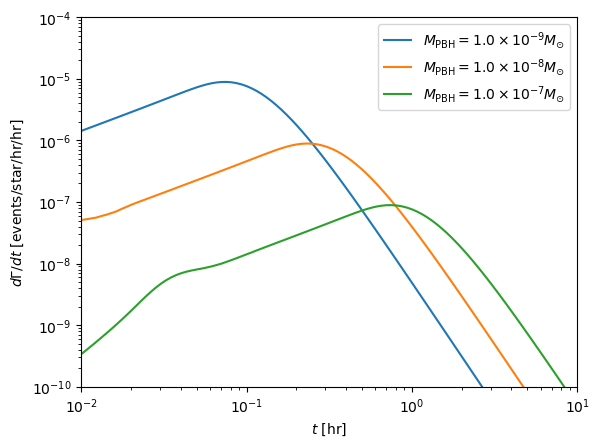

In [8]:
for i, pbh in enumerate(pbhs):
    # plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = " + str(pbh.m_pbh) + "M_{\odot}$")
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.m_pbh,0) + "$M_{\odot}$")


plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-10, 1e-4)

plt.legend()
plt.show()


In [9]:
#| hide
import nbdev; nbdev.nbdev_export()